# Applying SHRED to the Mice Dataset 

Dataset obtained from Allen Barain Atlas https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

Goal: Reconstruct mean unit activity post stimulus (both drifting grating and flashes)

Spike band: 
- ~30 kHz sample rate
- 500 Hz analog hi-pass
- 150 Hz digital hi-pass


LFP band: 
- ~2.5 kHz original sample rate
- 1000 Hz analog lo-pass
- 625 Hz digital lo-pass
- NWB includes every 2nd sample and every 4th channel

In [1]:
# Importing all dependencies 
import numpy as np
import numpy as np
import torch
import subprocess
import os
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import mne
from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.interpolate import CubicSpline
from scipy.io import loadmat
from sklearn.linear_model import Ridge

In [2]:
import xarray as xr
import pandas as pd
from scipy.ndimage import gaussian_filter
from pathlib import Path
import json
from IPython.display import display
from PIL import Image

from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

In [17]:
#Set up data cache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

data_directory = "/home/amy/SHRED_neuro/mice/data" #where data will be stored
manifest_path = os.path.join(data_directory, 'manifest.json')
cache = EcephysProjectCache.from_warehouse(manifest = manifest_path)

/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
sessions = cache.get_session_table()

print('Total number of sessions: ' + str(len(sessions)))

sessions.head()


# Can also filter which mice to select
filtered_sessions = sessions[(sessions.index == 756029989)]

filtered_sessions.head()

Total number of sessions: 58


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
756029989,2019-10-03T00:00:00Z,734865738,brain_observatory_1.1,96.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,684,2214,6,"[TH, DG, CA3, CA1, VISl, nan, PO, Eth, LP, VIS..."


In [19]:
#Loading dataset for specific session
session_id = 756029989 # for example
session = cache.get_session_data(session_id)

print([attr_or_method for attr_or_method in dir(session) if attr_or_method[0] != '_'])


/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


['DETAILED_STIMULUS_PARAMETERS', 'LazyProperty', 'age_in_days', 'api', 'channel_structure_intervals', 'channels', 'conditionwise_spike_statistics', 'ecephys_session_id', 'from_nwb_path', 'full_genotype', 'get_current_source_density', 'get_inter_presentation_intervals_for_stimulus', 'get_invalid_times', 'get_lfp', 'get_parameter_values_for_stimulus', 'get_pupil_data', 'get_screen_gaze_data', 'get_stimulus_epochs', 'get_stimulus_parameter_values', 'get_stimulus_table', 'inter_presentation_intervals', 'invalid_times', 'mean_waveforms', 'metadata', 'num_channels', 'num_probes', 'num_stimulus_presentations', 'num_units', 'optogenetic_stimulation_epochs', 'presentationwise_spike_counts', 'presentationwise_spike_times', 'probes', 'rig_equipment_name', 'rig_geometry_data', 'running_speed', 'session_start_time', 'session_type', 'sex', 'specimen_name', 'spike_amplitudes', 'spike_times', 'stimulus_conditions', 'stimulus_names', 'stimulus_presentations', 'structure_acronyms', 'structurewise_unit_c

**Obtaining mean spiking activity after 25 ms flash stimulus**

In [40]:
# We're going to build an array of spike counts surrounding stimulus presentation onset
# To do that, we will need to specify some bins (in seconds, relative to stimulus onset)
time_bin_edges = np.linspace(0, 0.25, 1000)
dt = 2/1000
sr = 1000/2
# look at responses to the flash stimulus
dg_2s_stimulus_presentation_ids = session.stimulus_presentations[
    session.stimulus_presentations['stimulus_name'] == 'flashes'
].index.values

# and get a set of units with only decent snr
decent_snr_unit_ids = session.units[
    session.units['snr'] >= 3
].index.values

spike_counts_da = session.presentationwise_spike_counts(
    bin_edges=time_bin_edges,
    stimulus_presentation_ids=dg_2s_stimulus_presentation_ids,
    unit_ids=decent_snr_unit_ids
)
spike_counts_da

<xarray.DataArray 'spike_counts' (stimulus_presentation_id: 150,
                                  time_relative_to_stimulus_onset: 999,
                                  unit_id: 243)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3647 .....
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 ...
  * unit_id                          (unit_id) int64 951814884 ... 951814096

In [41]:
mean_spike_counts = spike_counts_da.mean(dim='stimulus_presentation_id')
mean_spike_counts

<xarray.DataArray 'spike_counts' (time_relative_to_stimulus_onset: 999,
                                  unit_id: 243)>
array([[0.        , 0.        , 0.00666667, ..., 0.01333333, 0.        ,
        0.        ],
       [0.        , 0.00666667, 0.00666667, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.01333333, 0.01333333, ..., 0.00666667, 0.        ,
        0.        ],
       [0.        , 0.00666667, 0.00666667, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00666667, 0.        , ..., 0.01333333, 0.        ,
        0.00666667]])
Coordinates:
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 ...
  * unit_id                          (unit_id) int64 951814884 ... 951814096

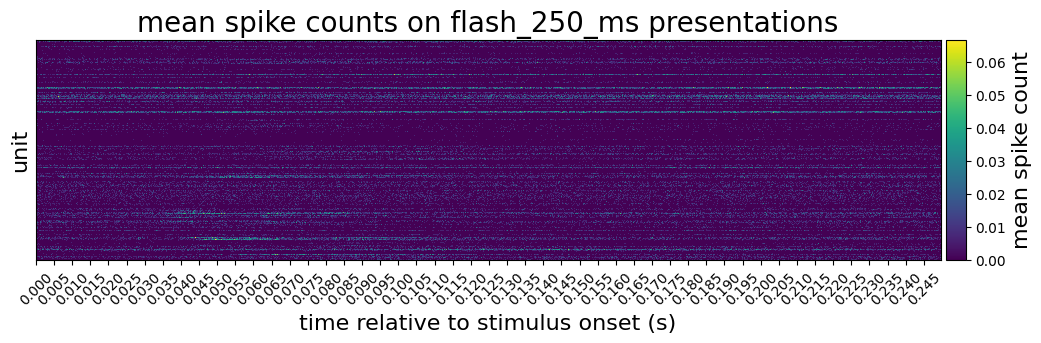

In [42]:
plot_spike_counts(
    mean_spike_counts, 
    mean_spike_counts['time_relative_to_stimulus_onset'],
    'mean spike count', 
    'mean spike counts on flash_250_ms presentations'
)
plt.show()

(999, 243)


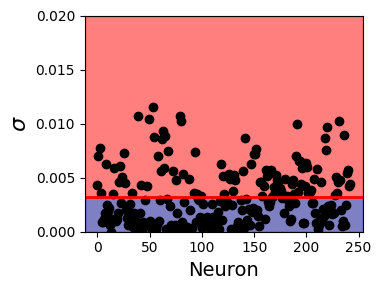

105


In [43]:
data_array = mean_spike_counts.values
print(data_array.shape)

var = np.std(data_array, axis = 0)
var_ave = np.mean(var)
neuron_index = np.arange(var.shape[0])

#plotting the distribution of std 
plt.figure(figsize = (4,3))
plt.axhspan(0, var_ave, color='darkblue', alpha=0.5)
plt.axhspan(var_ave,0.02 ,color='red', alpha=0.5)
plt.scatter(neuron_index, var, color = 'black', label = '$\sigma$')
plt.axhline(var_ave, color = 'red', linewidth = 2)
plt.xlabel('Neuron', fontsize = 14)
plt.ylabel('$\sigma$', fontsize = 16)
plt.ylim((0,0.02))
plt.tight_layout()
plt.show()

# Finding indices for high variance cases
high_ind = np.where(var > var_ave)[0]
print(high_ind.shape[0])


**Applying SHRED on Dataset**

In [ ]:
#Importing packages

os.environ["CUDA_VISIBLE_DEVICES"]="0"

os.chdir("../") 

# Change into the directory
os.chdir("/home/amy/SHRED_neuro/sindy-shred") ## Change to where the repo was cloned

from processdata import load_data
from processdata import TimeSeriesDataset
import sindy
import pysindy as ps
from pysindy.differentiation import FiniteDifference

os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.chdir("/home/amy/SHRED_neuro/sindy-shred")
import sindy_shred

In [45]:
load_X = data_array
print(load_X.shape)

n_t = load_X.shape[0]
n_s = load_X.shape[1]
stim = 'flash'
print(sr)
print(dt)
print(n_t)
print(n_s)


latent_dim = 64
poly_order = 1
include_sine = False
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)

num_neurons = 3
lags =  75
test_val_size = 200

train_indices = np.arange(0, n_t - lags - test_val_size)
mask = np.ones(n_t - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n_t - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[int(test_val_size/2):test_val_size]
test_indices = valid_test_indices[:int(test_val_size/2)]


(999, 243)
500.0
0.002
999
243


In [ ]:
# Randomly select the sensors from the CA1 region

for k in range(3,4):
    ind = np.random.choice(high_ind.shape[0], num_neurons, replace = False)
    neuron_locations = high_ind[ind]
    file_path = f"/home/amy/SHRED_neuro/mice/data_output/exp_Bii/neuron_loc_{stim}_{k}.npy"
    np.save(file_path, neuron_locations)
    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)
    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n_t - lags, lags, num_neurons))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = sindy_shred.SINDy_SHRED(num_neurons, n_s, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1,
                                    library_dim=library_dim, poly_order=poly_order,
                                    include_sine=include_sine, dt=dt, layer_norm=False).to(device)

    validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=200,
                                        lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=10.0,
                                        optimizer="AdamW", thres_epoch=100)

    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    mse_test = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    print('mse test', mse_test)
    train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
    train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())
    mse_train = np.linalg.norm(train_recons - train_ground_truth) / np.linalg.norm(train_ground_truth)
    print('mse train', mse_train)


    file_path = f"/home/amy/SHRED_neuro/mice/data_output/exp_Bii/train_recons_{stim}_{k}.npy"
    np.save(file_path, train_recons)
    file_path = f"/home/amy/SHRED_neuro/mice/data_output/exp_Bii/test_recons_{stim}_{k}.npy"
    np.save(file_path, test_recons)
    file_path = f"/home/amy/SHRED_neuro/mice/data_output/exp_Bii/train_gt_{stim}_{k}.npy"
    np.save(file_path, train_ground_truth)
    file_path = f"/home/amy/SHRED_neuro/mice/data_output/exp_Bii/test_gt_{stim}_{k}.npy"
    np.save(file_path, test_ground_truth)
    file_path = f"/home/amy/SHRED_neuro/mice/data_output/exp_Bii/mse_{stim}_{k}.npy"
    np.save(file_path, [mse_train, mse_test])

1 : tensor(0.0257, device='cuda:0', grad_fn=<AddBackward0>)
2 : tensor(0.0229, device='cuda:0', grad_fn=<AddBackward0>)
3 : tensor(0.0232, device='cuda:0', grad_fn=<AddBackward0>)
4 : tensor(0.0225, device='cuda:0', grad_fn=<AddBackward0>)
5 : tensor(0.0226, device='cuda:0', grad_fn=<AddBackward0>)
6 : tensor(0.0223, device='cuda:0', grad_fn=<AddBackward0>)
7 : tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>)
8 : tensor(0.0223, device='cuda:0', grad_fn=<AddBackward0>)
9 : tensor(0.0223, device='cuda:0', grad_fn=<AddBackward0>)
10 : tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>)
11 : tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>)
12 : tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>)
13 : tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>)
14 : tensor(0.0223, device='cuda:0', grad_fn=<AddBackward0>)
15 : tensor(0.0221, device='cuda:0', grad_fn=<AddBackward0>)
16 : tensor(0.0221, device='cuda:0', grad_fn=<AddBackward0>)
17 : tensor(0.0222, device='cuda:

Plot the results

(724, 243)
(100, 243)
(824, 243)


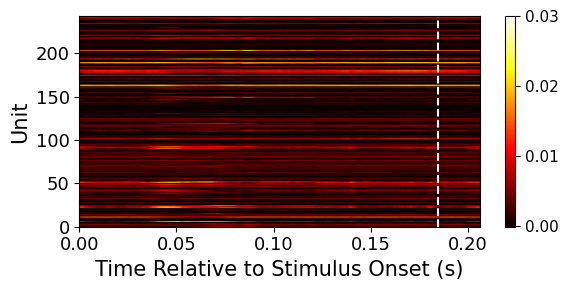

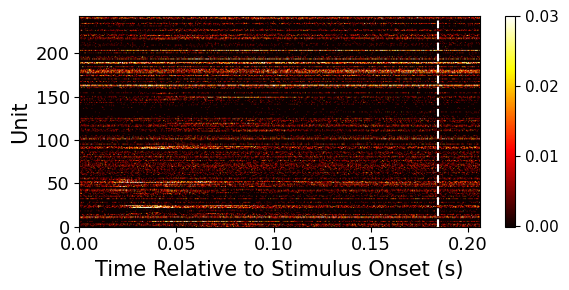

In [ ]:
## Flash

train = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_Bii/train_recons_flash_3.npy")
test = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_Bii/test_recons_flash_3.npy")
time = np.linspace(0, 0.2, 5)
data_recon = np.vstack((train,test))

print(train.shape)
print(test.shape)
print(data_recon.shape)
time_whole = np.linspace(0,0.21, data_recon.shape[0])

plt.figure(figsize = (6,3))
plt.imshow(data_recon.T, aspect ='auto', vmin = -0.0005e-1, vmax = 0.3e-1, extent=[0, 0.20625, 0, 243], cmap = 'hot')
plt.axvline(time_whole[724], color = 'w', linestyle = '--')
plt.xlabel('Time Relative to Stimulus Onset (s)', fontsize = 15)
plt.ylabel('Unit', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=13)

plt.xticks(time)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=11)
plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/mice/data_output/figs/unit_flash_recon.png", transparent = True, dpi = 400)

plt.show()

train = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_Bii/train_gt_flash_3.npy")
test = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_Bii/test_gt_flash_3.npy")
data_gt = np.vstack((train,test))

plt.figure(figsize = (6,3))
plt.imshow(data_gt.T, aspect ='auto', vmin = -0.0005e-1, vmax = 0.3e-1, extent=[0, 0.20625, 0, 243], cmap = 'hot')
plt.axvline(time_whole[724], color = 'w', linestyle = '--')

plt.xlabel('Time Relative to Stimulus Onset (s)', fontsize = 15)
plt.ylabel('Unit', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=13)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=11)

plt.xticks(time)
plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/mice/data_output/figs/unit_flash_gt.png", transparent = True, dpi = 400)

plt.show()

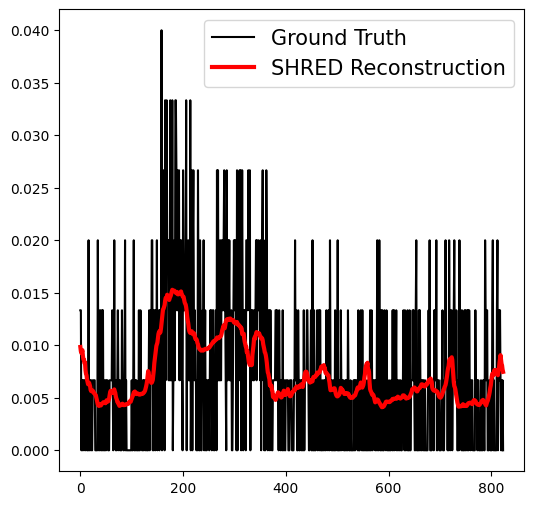

In [13]:
z = 150
plt.figure(figsize = (6,6))
plt.plot(data_gt[:,z].T, color = 'k', label = 'Ground Truth')
plt.plot(data_recon[:,z].T, color = 'r', linewidth = 3, label = 'SHRED Reconstruction')
plt.legend(fontsize = 15)
plt.savefig("/home/amy/SHRED_neuro/mice/data_output/figs/unit_flash_trace.png", transparent = True, dpi = 400)



(1649, 243)
(1449, 243)
1.4517597087378642


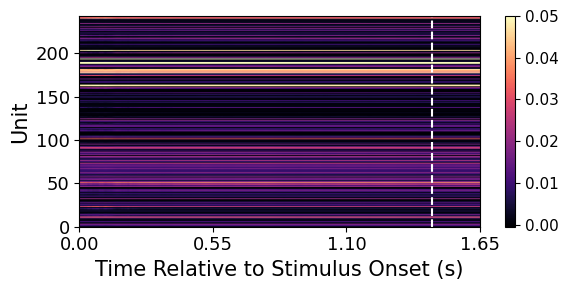

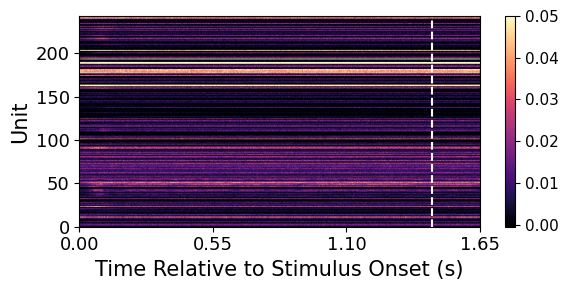

In [ ]:
## Drifting Grating

train = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_Bii/train_recons_dg_1.npy")
test = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_Bii/test_recons_dg_1.npy")
time = np.linspace(0, 1.65, 4)

data_recon = np.vstack((train,test))
print(data_recon.shape)
print(train.shape)
time_whole = np.linspace(0,1.65, data_recon.shape[0])
print(time_whole[1450])
plt.figure(figsize = (6,3))
plt.imshow(data_recon.T, aspect ='auto', vmin = -0.005e-1, vmax = 0.5e-1, extent=[0, 1.65, 0, 243], cmap = 'magma')
plt.axvline(time_whole[1450], color = 'w', linestyle = '--')

plt.xlabel('Time Relative to Stimulus Onset (s)', fontsize = 15)
plt.ylabel('Unit', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=13)

plt.xticks(time)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=11)
plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/mice/data_output/figs/unit_dg_recon.png", transparent = True, dpi = 400)

plt.show()

train = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_Bii/train_gt_dg_1.npy")
test = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_Bii/test_gt_dg_1.npy")
data_gt = np.vstack((train,test))

plt.figure(figsize = (6,3))
plt.imshow(data_gt.T, aspect ='auto', vmin = -0.005e-1, vmax = 0.5e-1, extent=[0, 1.65, 0, 243], cmap = 'magma')
plt.axvline(time_whole[1450], color = 'w', linestyle = '--')

plt.xlabel('Time Relative to Stimulus Onset (s)', fontsize = 15)
plt.ylabel('Unit', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=13)

plt.xticks(time)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=11)
plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/mice/data_output/figs/unit_dg_gt.png", transparent = True, dpi = 400)

plt.show()


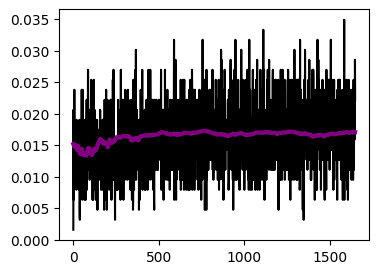

In [73]:
z = 150
plt.figure(figsize = (4,3))
plt.plot(data_gt[:,z].T, color = 'k', label = 'Ground Truth')
plt.plot(data_recon[:,z].T, color = 'purple', linewidth = 3, label = 'SHRED reconstruction')
plt.savefig("/home/amy/SHRED_neuro/mice/data_output/figs/unit_dg_trace.png", transparent = True, dpi = 400)